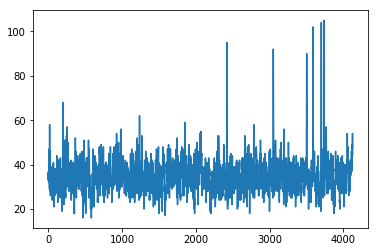

average = 26.98840194451901
coverage = 0.9997347236494458


In [51]:
#Genome coverage (graph, percentage of genome covered, average coverage)

import pysam
import pyBigWig
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

bw_1000_f = 'ONT_2D_1000.bw'
bw_1_f = 'ONT_2D.bw'
bam_f = 'ONT_2D_MD.sam'
#C24-698
#C24-698_bwamem

bw_1000 = open('/Users/dashabalashova/ngs_institute/HW3/'+bw_1000_f, 'r')
a = []
for r in bw_1000.read().splitlines():
    a.append(int(r.split('\t')[-1]))

plt.figure()
plt.plot(a)
plt.show()

bw = open('/Users/dashabalashova/ngs_institute/HW3/'+bw_1_f, 'r')
a = []
for r in bw.read().splitlines():
    a.append(int(r.split('\t')[-1]))

print('average =', np.mean(a))
print('coverage =', (len(a)-a.count(0))/len(a))

In [42]:
#Table of frequencies of replacements / insertions / deletions and and lengths of indels hist


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


bamfile = pysam.AlignmentFile(bam_f, 'rb')

a = np.array([[0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0]])

frame = pd.DataFrame(a, index=['A','C','G','T','-'], columns=['A','C','G','T','-'])

N = 0
indel = []

insertion_s = ''
deletion_s = ''
mism_read_s = ''
mism_ref_s = ''
indels_lengths = []
M = 0
for alignment in bamfile.fetch():
    if alignment.cigarstring!=None and str(alignment).split()[9]!='None':
        read = alignment.query_sequence
        #print(str(alignment).split()[9],'\n')
        #print()
        ref = alignment.get_reference_sequence()
        mapping = alignment.get_aligned_pairs(matches_only=True, with_seq=True)
        n_read = 0
        n_ref = 0
        
        for i in alignment.cigar:
            
            if i[0]==4: #start_insertion
                insertion_s += read[n_read:n_read+i[1]]
                indels_lengths.append(i[1])
                n_read += i[1]
            
            if i[0]==0: #match
                for n in range(0,i[1]):
                    if ref[n_ref:n_ref+i[1]][n].islower()==True:
                        mism_read_s+=read[n_read:n_read+i[1]][n]
                        mism_ref_s+=ref[n_ref:n_ref+i[1]][n]
                n_read += i[1]
                n_ref += i[1]
                         
            if i[0]==1: #BAM_CINS
                insertion_s += read[n_read:n_read+i[1]]
                indels_lengths.append(i[1])
                n_read += i[1]
                
            if i[0]==2: #BAM_CDEL
                deletion_s += ref[n_ref:n_ref+i[1]]
                indels_lengths.append(i[1])
                n_ref += i[1]
                             
                
for n in range(0,len(mism_read_s)):
    frame[mism_ref_s[n].upper()][mism_read_s[n]] += 1       

for i in insertion_s:
    frame['-'][i] += 1
    
for i in deletion_s:
    frame[i]['-'] += 1
    
    
frame

,A,C,G,T,-
A,0,137046,319761,107765,1044879
C,112963,0,91353,372780,935420
G,368487,85027,0,111447,955334
T,105373,340675,126487,0,1039702
-,1608029,1537154,1559017,1604787,0


In [43]:
import pandas as pd

pd.value_counts(indels_lengths).to_frame().reset_index()

,index,0
0,1,2424275
1,2,967613
2,3,451010
3,4,178034
4,5,86440
5,6,49042
6,7,26230
7,8,15883
8,9,10937
9,10,6863


In [48]:






#Статистика дин инделов в завимости от длины гомополимерного участка на примере 'AAAAA'

import pysam
import re


def find(sst, st):
    st = st.upper()
    u = [m.start() for m in re.finditer(sst, st)]
    u2 = []
    for n in range(0,len(u)):      
        if u[n]+len(sst)>=len(st):
            u2.append(u[n])
        elif st[u[n]+len(sst)]!=sst[0]:
            u2.append(u[n])
    return u2

def map_f(mapping, read, position, sst):
    u=[]
    R = mapping[0][1]
    for m in mapping:
        if m[1] in range(position+R, position+len(sst)+R):
            u.append(m[0])
    if u==[]:
        return 'N'
    s1 = 0
    s2 = 0
    while (max(u)+1<len(read) and s1==0):
        if read[max(u)+1]==gomo[0]:
            u.append(max(u)+1)
        else:
            s1=1
    while (min(u)-1>=0 and s2==0):
        if read[min(u)-1]==gomo[0]:
            u.append(min(u)-1)
        else:
            s2=1           
    return read[min(u):max(u)+1] 

def ch(st):
    n=25
    while n>0:
        if st.count('A'*n)>0:
            return 'A'*n
        else:
            n-=1
    return ''

samfile = pysam.AlignmentFile(bam_f, "rb")
n=0
g_arr = []
for alignment in samfile.fetch():
    gomo = 'AAAAA'
    if alignment.cigarstring!=None and str(alignment).split()[9]!='None':
        mapping = alignment.get_aligned_pairs(matches_only=True, with_seq=True)
        read = alignment.query_sequence
        ref = alignment.get_reference_sequence()
        
       
        for p in find(gomo, ref):
            a = map_f(mapping, read, p, gomo)
            g_arr.append(ch(a))    
        n+=1
    else:
        break
        

for a in set(g_arr):
    if a!='':
        print(a, g_arr.count(a))

AAAAA 45
AAAA 68
AA 1
AAA 6


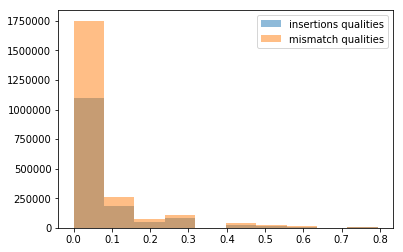

insertion mean percent = 1.25%
mismatch mean percent = 1.83%


In [49]:
#Средний процент ошибок в ридах, Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде и при замене

import pysam
import matplotlib.pyplot as plt
import numpy as np

samfile = pysam.AlignmentFile(bam_f, "rb")
g_arr = []

qual_MIS_num = []
qual_I_num = []
insertion_rate = []
mismatch_rate = []

for alignment in samfile.fetch():
    if alignment.cigarstring!=None and str(alignment).split()[9]!='None':
        read = alignment.query_sequence
        quality = alignment.qual
        ref = alignment.get_reference_sequence()
        count_I = 0
        qual_I = ''
        count_MIS = 0
        qual_MIS = ''
        i_n = 0
        for i in alignment.cigar:
            if i[0]==1:
                count_I+=i[1]
                qual_I += quality[i_n:i_n+i[1]]
            i_n += i[1] 

        i_n = 0
        for i in alignment.get_aligned_pairs(matches_only=True, with_seq=True):
            if i[2].islower() == True:
                count_MIS+=1
                qual_MIS_num.append(10**-((ord(quality[i_n])-33)/10.0))
            i_n += 1
            
        for i in qual_I:
            qual_I_num.append(10**-((ord(i)-33)/10.0))
            
        insertion_rate.append(count_I/len(read))
        mismatch_rate.append(count_MIS/len(read))

        

plt.figure(1)
plt.hist(qual_I_num, rwidth = 2, alpha = 0.5, label = "insertions qualities") 
plt.hist(qual_MIS_num, rwidth = 2, alpha = 0.5, label = "mismatch qualities")
plt.legend(loc = 'upper right')
plt.show()
        
print('insertion mean percent =', "{0:.2%}".format(np.mean(insertion_rate)))
print('mismatch mean percent =', "{0:.2%}".format(np.mean(mismatch_rate)))